In [1]:
import pandas as pd
import json
import requests
import copy
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn import model_selection, preprocessing, metrics
import seaborn as sns
import estateFunction
import time

In [2]:
import gc 
gc.collect()

31

In [3]:
###경제상황을 반영해주기 위해 각종 지수들을 넣어줌.

###공동주택 실거래 가격지수 아파트 
apartIndex=pd.read_csv("indexData/apartIndex.csv",encoding="cp949")
apartIndex=list((apartIndex.iloc[10].reset_index())[10])[2:]
###경기종합 선행 지수
economicIndex=pd.read_csv("indexData/economicPredictionIndex.csv",encoding="cp949")
economicIndex=list((economicIndex.iloc[10].reset_index()[10])[1:])
###생산자 물가 지수
produceIndex=pd.read_csv("indexData/produceIndex.csv",encoding="cp949")
produceIndex=list((produceIndex.iloc[10].reset_index()[10])[1:])
###소비자 물가 지수
spendIndex=pd.read_csv("indexData/spendIndex.csv",encoding="cp949")
spendIndex=list((spendIndex.iloc[10].reset_index()[10])[1:])

In [4]:
###2018/12데이터를 예측하므로 2018/11까지 있어야됨
###2018/12데이터에는 2018/11데이터넣음
###2010/01데이터에는 2009/12데이터넣음
def makeApartIndex(x):
    index=(x-201001)//100*12+(x-201001)%100
    return apartIndex[index]
def makeEconomicIndex(x):
    index=(x-201001)//100*12+(x-201001)%100
    return economicIndex[index]
def makeSpendIndex(x):
    index=(x-201001)//100*12+(x-201001)%100
    return spendIndex[index]
def makeProduceIndex(x):
    index=(x-201001)//100*12+(x-201001)%100
    return produceIndex[index]

In [5]:
kfoldData=pd.read_csv("dataAfterPreprocess/finaltrain")  
kfoldTarget=kfoldData['거래금액(만원)']
#target값 삭제해주고 나머지 변수들은 훈련에 사용될 수 없음
del kfoldData['거래금액(만원)']
del kfoldData['시군구']
del kfoldData['번지']
del kfoldData['본번']
del kfoldData['부번']
###object에서 category로 바꾸어주어야함
kfoldData['단지명']=kfoldData['단지명'].astype('category')
kfoldData['도로명']=kfoldData['도로명'].astype('category')
kfoldData['big']=kfoldData['big'].astype('category')
kfoldData['small']=kfoldData['small'].astype('category')

In [6]:
kfoldData['apartIndex']=kfoldData['계약년월'].apply(makeApartIndex).astype('float')
kfoldData['economicIndex']=kfoldData['계약년월'].apply(makeEconomicIndex).astype('float')
kfoldData['spendIndex']=kfoldData['계약년월'].apply(makeSpendIndex).astype('float')
kfoldData['produceIndex']=kfoldData['계약년월'].apply(makeProduceIndex).astype('float')

In [7]:
kfoldTest=pd.read_csv("dataAfterPreprocess/finaltest")
testTarget=kfoldTest["거래금액(만원)"]/kfoldTest['전용면적(㎡)']
#target값 삭제해주고 나머지 변수들은 훈련에 사용될 수 없음
del kfoldTest['거래금액(만원)']
del kfoldTest['시군구']
del kfoldTest['번지']
del kfoldTest['본번']
del kfoldTest['부번']
del kfoldTest['공시가격']
del kfoldTest['공시가격(만원)']
###object에서 category로 바꾸어주어야함
kfoldTest['단지명']=kfoldTest['단지명'].astype('category')
kfoldTest['도로명']=kfoldTest['도로명'].astype('category')
kfoldTest['big']=kfoldTest['big'].astype('category')
kfoldTest['small']=kfoldTest['small'].astype('category')

In [8]:
kfoldTest['apartIndex']=kfoldTest['계약년월'].apply(makeApartIndex).astype('float')
kfoldTest['economicIndex']=kfoldTest['계약년월'].apply(makeEconomicIndex).astype('float')
kfoldTest['spendIndex']=kfoldTest['계약년월'].apply(makeSpendIndex).astype('float')
kfoldTest['produceIndex']=kfoldTest['계약년월'].apply(makeProduceIndex).astype('float')

In [9]:
kfoldData.columns=['Apart name','USM','Sold date','Storey','Build year','Street name','latitude','longitude','District','dong',
                   'Sold month','Apart index','Leading index','Consumer index', 'Producer index']
kfoldTest.columns=['Apart name','USM','Sold date','Storey','Build year','Street name','latitude','longitude','District','dong',
                   'Sold month','Apart index','Leading index','Consumer index', 'Producer index']
###ppsm으로 고쳐줘야 되므로
kfoldTarget=kfoldTarget/kfoldData['USM']

In [10]:
len(kfoldData),len(kfoldTarget),len(kfoldTest),len(testTarget)

(554484, 554484, 1192, 1192)

In [11]:
SST=sum((testTarget-np.mean(testTarget))**2)

In [12]:
###big제외하고 원핫인코딩하기에는 너무 많다.
kfoldDataWithBig=copy.deepcopy(kfoldData)
kfoldTestWithBig=copy.deepcopy(kfoldTest)
del kfoldDataWithBig['Apart name']
del kfoldDataWithBig['Street name']
del kfoldDataWithBig['dong']
del kfoldTestWithBig['Apart name']
del kfoldTestWithBig['Street name']
del kfoldTestWithBig['dong']

In [13]:
cat_features = ['District'] 

for column in cat_features:
    temp = pd.get_dummies(pd.Series(kfoldDataWithBig[column])) 
    kfoldDataWithBig = pd.concat([kfoldDataWithBig,temp],axis=1) 
    kfoldDataWithBig = kfoldDataWithBig.drop([column],axis=1) 

for column in cat_features: 
    temp = pd.get_dummies(pd.Series(kfoldTestWithBig[column])) 
    kfoldTestWithBig = pd.concat([kfoldTestWithBig,temp],axis=1) 
    kfoldTestWithBig = kfoldTestWithBig.drop([column],axis=1)

In [14]:
%%time
#OLS
from sklearn.linear_model import LinearRegression
reg=LinearRegression()
reg.fit(kfoldDataWithBig,kfoldTarget)
olsPre=reg.predict(kfoldTestWithBig)
olsOof=reg.predict(kfoldDataWithBig)
reg.intercept_,reg.coef_

Wall time: 2.58 s


(-128470.19241854764,
 array([-1.16417498e+00,  6.45787951e-02,  5.82930381e+00,  1.19184811e+00,
         1.51093348e+03,  4.52642685e+02,  9.08056340e-01,  9.42476244e-01,
         2.52224327e+01, -4.67698245e+01,  1.56314833e+01,  6.09569764e+02,
        -4.76692523e+01, -3.08028754e+02, -3.66839959e+01,  1.38184853e+01,
         5.50071698e+01, -2.47627368e+01, -2.74196253e+01, -3.43253945e+02,
        -3.91517750e+02, -1.92616874e+02,  1.25332323e+02,  1.01717714e+02,
        -1.08148632e+02,  4.98801933e+02,  5.67780256e+01, -2.20479295e+02,
         2.65796727e+02,  1.18289342e+02,  7.91072611e+01,  3.00358590e+02,
        -1.87127743e+02, -3.56352094e+01,  5.23398860e+00, -3.06467509e+02]))

In [16]:
(abs(testTarget-olsPre)/testTarget*100).describe()

count    1192.000000
mean       28.202662
std        26.771109
min         0.023861
25%        10.254658
50%        22.053936
75%        37.237967
max       247.591419
dtype: float64

In [15]:
1-sum((testTarget-olsPre)**2)/SST

0.42716389407354716

In [45]:
%%time
###randomforest 단일모델
from sklearn.ensemble import RandomForestRegressor
rfOof = np.zeros(len(kfoldDataWithBig))
rfPre = np.zeros(len(kfoldTestWithBig)) 
folds=KFold(n_splits=5,shuffle=True,random_state=15)

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(kfoldDataWithBig,kfoldTarget)) : 
    print(n_fold)
    trn_x, trn_y = kfoldDataWithBig.iloc[trn_idx], kfoldTarget[trn_idx] 
    val_x, val_y = kfoldDataWithBig.iloc[val_idx], kfoldTarget[val_idx] 
    ranFo=RandomForestRegressor(n_estimators=200, max_depth=50, n_jobs=-1)
    ranFo.fit(trn_x,trn_y)
    
    rfOof[val_idx]=ranFo.predict(val_x)
    rfPre+=ranFo.predict(kfoldTestWithBig)/folds.n_splits

0
1
2
3
4
Wall time: 23min 6s


In [46]:
(abs(testTarget-rfPre)/testTarget*100).describe()

count    1192.000000
mean        9.470733
std        12.849804
min         0.036512
25%         2.914074
50%         6.092453
75%        10.634049
max       148.447821
dtype: float64

In [47]:
1-sum((testTarget-rfPre)**2)/SST

0.940817873695857

In [ ]:
###xgboost 단일모델 
xgboost.train(params, dtrain, num_boost_round=10, 
              evals=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None, 
              evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None, learning_rates=None)
evals (list of pairs (DMatrix, string)) – List of validation sets for which metrics will evaluated during training. 
Validation metrics will help us track the performance of the model.

In [17]:
%%time
###범주형 변수 big만 남겼음
###속도가 빨라짐
xgbOof = np.zeros(len(kfoldDataWithBig))
xgbPre = np.zeros(len(kfoldTestWithBig)) 
folds=KFold(n_splits=5,shuffle=True,random_state=15)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(kfoldDataWithBig,kfoldTarget)) : 
    trn_x, trn_y = kfoldDataWithBig.iloc[trn_idx], kfoldTarget[trn_idx] 
    val_x, val_y = kfoldDataWithBig.iloc[val_idx], kfoldTarget[val_idx] 
    params = {'objective': 'reg:linear', 
              'booster':'gbtree',                   ###Tree base 모델
              'eval_metric': 'mae', 
              'eta': 0.1,           ###학습속도 일반적으로 0.01~0.2
              'max_depth': 11,    ###트리 최대깊이 일반적으로 3~10
              'subsample': 0.9,    ###각 트리마다 관측 데이터 샘플링 비율 0.5~1
              'colsample_bytree': 0.9,   ###각 트리마다 변수 샘플링 비율 0.5~1
              'alpha':0.001,                    ###규제항 
              'random_state': 42, 
              'verbosity': 1}                ###동작메시지 출력
    tr_data = xgb.DMatrix(trn_x, trn_y) 
    va_data = xgb.DMatrix(val_x, val_y) 
    watchlist = [(tr_data, 'train'), (va_data, 'valid')] 
    model_xgb = xgb.train(params, tr_data, 10000, watchlist, maximize=False, early_stopping_rounds = 500, verbose_eval=100) 
    
    test_data = xgb.DMatrix(kfoldTestWithBig) 
    xgbPre += model_xgb.predict(test_data) / folds.n_splits 
    xgbOof[val_idx] = model_xgb.predict(va_data)

C:\Users\ju\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[20:43:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-mae:580.727	valid-mae:580.879
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 500 rounds.
[100]	train-mae:33.8316	valid-mae:37.4107
[200]	train-mae:27.7638	valid-mae:32.5492
[300]	train-mae:24.8002	valid-mae:30.4701
[400]	train-mae:22.4259	valid-mae:28.9813
[500]	train-mae:20.728	valid-mae:28.0592
[600]	train-mae:19.3883	valid-mae:27.4295
[700]	train-mae:18.2561	valid-mae:26.9505
[800]	train-mae:17.3205	valid-mae:26.6233
[900]	train-mae:16.5268	valid-mae:26.3582
[1000]	train-mae:15.7848	valid-mae:26.1475
[1100]	train-mae:15.0906	valid-mae:25.9907
[1200]	train-mae:14.4207	valid-mae:25.8548
[1300]	train-mae:13.823	valid-mae:25.7524
[1400]	train-mae:13.2697	valid-mae:25.6754
[1500]	train-mae:12.7531	valid-mae:25.6202
[1700]	train-mae:1

In [18]:
(abs(testTarget-xgbPre)/testTarget*100).describe()

count    1192.000000
mean        7.652526
std        10.544603
min         0.001702
25%         2.036775
50%         4.702779
75%         9.062193
max       117.238530
dtype: float64

In [19]:
1-sum((testTarget-xgbPre)**2)/SST

0.9592801172528781

In [20]:
###lightgbm 파라미터
param = {'num_leaves': 200,                 #default=31
         'min_data_in_leaf': 10,            #default=20
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.1,           ###트리만들때마다 0.01 씩 가중치 곱함
         "boosting": "gbdt",                ###워래 우리가 아는 gbdt 씀
         "feature_fraction": 0.9,          ###변수 90%만 쓰게됨
         "bagging_freq": 1,                 ###bagging 의빈도
         "bagging_fraction": 0.9,        ###데이터를 90%만 쓰게됨 resampling 없이
         "bagging_seed": 11,              ###bagging 을 위한 seed
         "metric": 'mae',
         "lambda_l1": 0.1,                  ###오메가 항에서 람다 말할는거임 가중치 옆에 붙는 weights 숫자가 클수록 보수적
         "verbosity": -1}                      ###보수적이라는말은 트리생성을 잘안할려고함

In [21]:
#lightgbm단일모델인데 범주형 변수 제외하고 이거는 가변수 쓰지말고 그냥 big 그대로 쓰자
lightgbmOof=np.zeros(len(kfoldDataWithBig))
lightgbmPre=np.zeros(len(kfoldTestWithBig))
kfoldData2=copy.deepcopy(kfoldData)
kfoldTest2=copy.deepcopy(kfoldTest)
del kfoldData2['Apart name']
del kfoldData2['Street name']
del kfoldData2['dong']
del kfoldTest2['Apart name']
del kfoldTest2['Street name']
del kfoldTest2['dong']

In [22]:
%%time
folds=KFold(n_splits=5,shuffle=True,random_state=15)
feature_importance_df = pd.DataFrame()
features=kfoldData2.columns
for order, (train_idx,valid_idx) in enumerate(folds.split(kfoldData2, kfoldTarget)):
    print('-')
    print("Fold {}".format(order + 1))
    trn_data = lgb.Dataset(kfoldData2.iloc[train_idx], label=kfoldTarget.iloc[train_idx])
    val_data = lgb.Dataset(kfoldData2.iloc[valid_idx], label=kfoldTarget.iloc[valid_idx])

    num_round = 10000          ###boosting 10000번 한다는소리임 verbose_eval 은 100번마다 출력함
    ###early는 100번동안 효과없으면 그만둠
    
    clf = lgb.train(param, trn_data, num_round, valid_sets = [val_data], verbose_eval=100, early_stopping_rounds=300)
    #훈련해서 모수가 조정된 모델에 valid 데이터 넣어서 예측값 보여주는것
    lightgbmOof[valid_idx] = clf.predict(kfoldData2.iloc[valid_idx], num_iteration=clf.best_iteration)
    ###5개모델 다더해서 나누면 최종 예측치 되는것
    lightgbmPre += clf.predict(kfoldTest2, num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"]=features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["order"] = order + 1
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

-
Fold 1
Training until validation scores don't improve for 300 rounds
[100]	valid_0's l1: 44.2597
[200]	valid_0's l1: 37.5658
[300]	valid_0's l1: 34.6782
[400]	valid_0's l1: 32.8785
[500]	valid_0's l1: 31.5153
[600]	valid_0's l1: 30.5682
[700]	valid_0's l1: 29.8262
[800]	valid_0's l1: 29.3184
[900]	valid_0's l1: 28.8723
[1000]	valid_0's l1: 28.525
[1100]	valid_0's l1: 28.2545
[1200]	valid_0's l1: 28.0441
[1300]	valid_0's l1: 27.8489
[1400]	valid_0's l1: 27.6922
[1500]	valid_0's l1: 27.5571
[1600]	valid_0's l1: 27.4485
[1700]	valid_0's l1: 27.331
[1800]	valid_0's l1: 27.2207
[1900]	valid_0's l1: 27.1594
[2000]	valid_0's l1: 27.0778
[2100]	valid_0's l1: 27.012
[2200]	valid_0's l1: 26.9659
[2300]	valid_0's l1: 26.9299
[2400]	valid_0's l1: 26.8875
[2500]	valid_0's l1: 26.8539
[2600]	valid_0's l1: 26.8297
[2700]	valid_0's l1: 26.803
[2800]	valid_0's l1: 26.7842
[2900]	valid_0's l1: 26.7596
[3000]	valid_0's l1: 26.745
[3100]	valid_0's l1: 26.7255
[3200]	valid_0's l1: 26.7107
[3300]	valid_0'

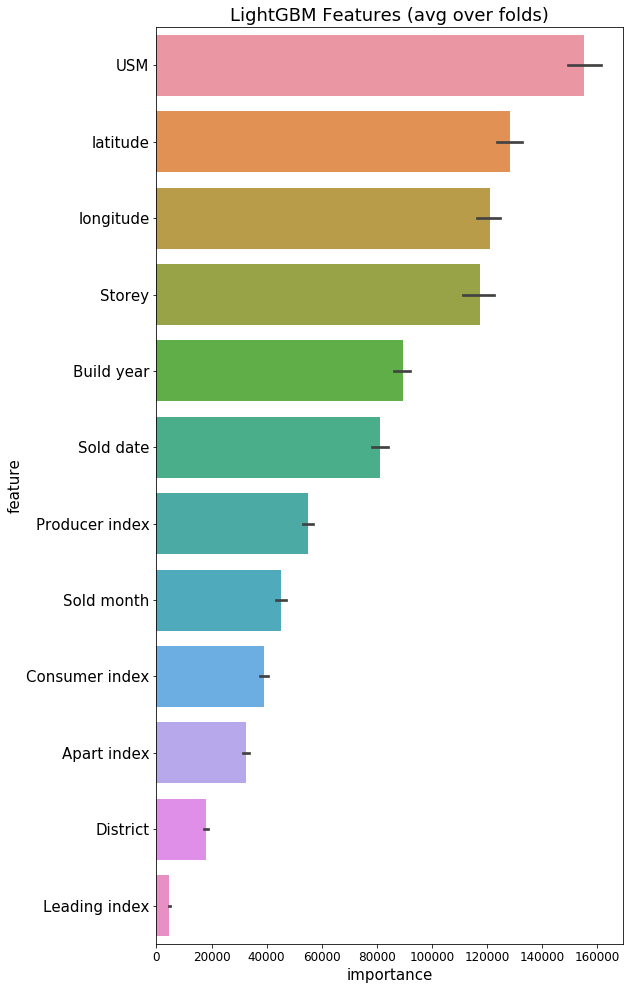

In [23]:
cols = (feature_importance_df[["feature", "importance"]].groupby("feature").mean()
        .sort_values(by="importance", ascending=False)[:20].index)
###각변수들 평규내서 위에서 상위 20개뽑는것
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
                ###20개중에서 해당하는 변수가 중복으로 뽑히게됨 결과로 보니 그런듯
                ###그런데 그림으로 그릴때는 이게 합쳐지는듯
plt.figure(figsize=(9,14))
plt.rc('font',size=15)
plt.rc('xtick',labelsize=12)
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('big_lgbm_importances.png')

In [24]:
(abs(testTarget-lightgbmPre)/testTarget*100).describe()

count    1192.000000
mean        8.039688
std        10.453550
min         0.014470
25%         2.481716
50%         5.141844
75%         9.722247
max       104.985120
dtype: float64

In [25]:
1-sum((testTarget-lightgbmPre)**2)/SST

0.9589744435154068

In [ ]:
#차이 많이나는거 왜 많이 나는지 살펴 볼려고 하는것

In [31]:
kfoldTest3=copy.deepcopy(kfoldTest)

In [32]:
kfoldTest3['answer']=testTarget
kfoldTest3['prediction']=lightgbmPre
kfoldTest3['abss']=abs(testTarget-lightgbmPre)

In [33]:
kfoldTest3=kfoldTest3.sort_values(['abss'],ascending=False)

In [34]:
kfoldTest4=kfoldTest3[:200]

In [35]:
from collections import Counter
Counter(kfoldTest4['District'])

Counter({'송파구': 20,
         '강남구': 33,
         '용산구': 7,
         '서초구': 19,
         '은평구': 8,
         '마포구': 11,
         '동대문구': 8,
         '광진구': 6,
         '종로구': 4,
         '양천구': 9,
         '성동구': 9,
         '강서구': 12,
         '강동구': 10,
         '영등포구': 6,
         '구로구': 4,
         '성북구': 5,
         '관악구': 2,
         '중구': 4,
         '노원구': 9,
         '금천구': 1,
         '강북구': 2,
         '동작구': 4,
         '중랑구': 3,
         '서대문구': 2,
         '도봉구': 2})

In [36]:
kfoldTest4[:10]

,Apart name,USM,Sold date,Storey,Build year,Street name,latitude,longitude,District,dong,Sold month,Apart index,Leading index,Consumer index,Producer index,answer,prediction,abss
368,미성,46.54,201812,5,1980,올림픽로33길,37.517513,127.107039,송파구,신천동,12,101.9,113.4,104.71,103.53,1912.978083,2554.986649,642.008566
156,다우림하우스,131.88,201812,2,2006,영동대로128길,37.518954,127.061695,강남구,삼성동,12,101.9,113.4,104.71,103.53,621.777373,1257.655289,635.877916
458,산호,40.46,201812,11,1977,원효로,37.532717,126.950382,용산구,원효로4가,12,101.9,113.4,104.71,103.53,2100.840336,1481.601606,619.238730
1002,푸른마을,108.45,201812,6,2003,동광로1길,37.495644,126.984015,서초구,방배동,12,101.9,113.4,104.71,103.53,507.146150,1007.892952,500.746802
866,제각말(푸르지오8단지),134.19,201812,11,2010,연서로48길,37.628429,126.932129,은평구,진관동,12,101.9,113.4,104.71,103.53,1140.174380,645.780637,494.393743
148,뉴마인,59.24,201812,1,2008,마포대로14길,37.547593,126.957279,마포구,신공덕동,12,101.9,113.4,104.71,103.53,675.219446,1092.442620,417.223174
310,레베빌(86-10),244.15,201812,1,1998,동광로39길,37.495361,126.999674,서초구,반포동,12,101.9,113.4,104.71,103.53,1228.752816,841.753964,386.998852
152,다성리치빌,84.94,201812,2,2001,백제고분로37길,37.504048,127.103311,송파구,석촌동,12,101.9,113.4,104.71,103.53,647.515894,979.769308,332.253415
246,동일스카이시티2차,66.87,201812,2,2005,회기로,37.590940,127.048153,동대문구,회기동,12,101.9,113.4,104.71,103.53,396.291311,727.243720,330.952408
1037,한솔마을,84.73,201812,5,1994,광평로10길,37.481888,127.077511,강남구,일원동,12,101.9,113.4,104.71,103.53,1546.087572,1851.724413,305.636841


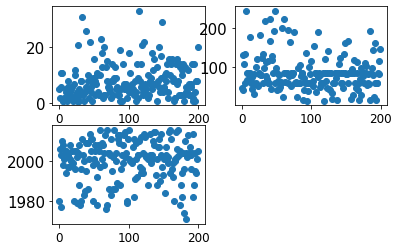

In [41]:
from matplotlib import pyplot as plt
import numpy as np
plt.subplot(2,2,1)
plt.scatter(range(0,200),kfoldTest4['Storey'])
plt.subplot(2,2,2)
plt.scatter(range(0,200),kfoldTest4['USM'])
plt.subplot(2,2,3)
plt.scatter(range(0,200),kfoldTest4['Build year'])
plt.show()

In [26]:
%%time
###lightgbm 데이터 다쓰는것 범주형 다쓰는거임
lightgbmOof2=np.zeros(len(kfoldData))
lightgbmPre2=np.zeros(len(kfoldTest))
folds=KFold(n_splits=5,shuffle=True,random_state=15)
feature_importance_df2 = pd.DataFrame()
features2=kfoldData.columns
for order, (train_idx,valid_idx) in enumerate(folds.split(kfoldData, kfoldTarget)):
    print('-')
    print("Fold {}".format(order + 1))
    trn_data = lgb.Dataset(kfoldData.iloc[train_idx], label=kfoldTarget.iloc[train_idx])
    val_data = lgb.Dataset(kfoldData.iloc[valid_idx], label=kfoldTarget.iloc[valid_idx])

    num_round = 10000          ###boosting 10000번 한다는소리임 verbose_eval 은 100번마다 출력함
    ###early는 100번동안 효과없으면 그만둠
    
    clf = lgb.train(param, trn_data, num_round, valid_sets = [val_data], verbose_eval=100, early_stopping_rounds=100)
    #훈련해서 모수가 조정된 모델에 valid 데이터 넣어서 예측값 보여주는것
    lightgbmOof2[valid_idx] = clf.predict(kfoldData.iloc[valid_idx], num_iteration=clf.best_iteration)
    ###5개모델 다더해서 나누면 최종 예측치 되는것
    lightgbmPre2 += clf.predict(kfoldTest, num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance_df2 = pd.DataFrame()
    fold_importance_df2["feature"]=features2
    fold_importance_df2["importance"] = clf.feature_importance()
    fold_importance_df2["order"] = order + 1
    
    feature_importance_df2 = pd.concat([feature_importance_df2, fold_importance_df2], axis=0)

-
Fold 1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 28.8466
[200]	valid_0's l1: 27.3836
[300]	valid_0's l1: 26.8065
[400]	valid_0's l1: 26.3936
[500]	valid_0's l1: 26.1432
[600]	valid_0's l1: 25.955
[700]	valid_0's l1: 25.8081
[800]	valid_0's l1: 25.6784
[900]	valid_0's l1: 25.5809
[1000]	valid_0's l1: 25.5126
[1100]	valid_0's l1: 25.4497
[1200]	valid_0's l1: 25.4049
[1300]	valid_0's l1: 25.3509
[1400]	valid_0's l1: 25.3085
[1500]	valid_0's l1: 25.2781
[1600]	valid_0's l1: 25.2579
[1700]	valid_0's l1: 25.2435
[1800]	valid_0's l1: 25.2277
[1900]	valid_0's l1: 25.2215
[2000]	valid_0's l1: 25.2091
[2100]	valid_0's l1: 25.1992
[2200]	valid_0's l1: 25.1908
[2300]	valid_0's l1: 25.1875
[2400]	valid_0's l1: 25.1846
Early stopping, best iteration is:
[2369]	valid_0's l1: 25.1828
-
Fold 2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 28.8222
[200]	valid_0's l1: 27.3936
[300]	valid_0's l1: 26.8393
[400]	valid_0's l1: 26.4

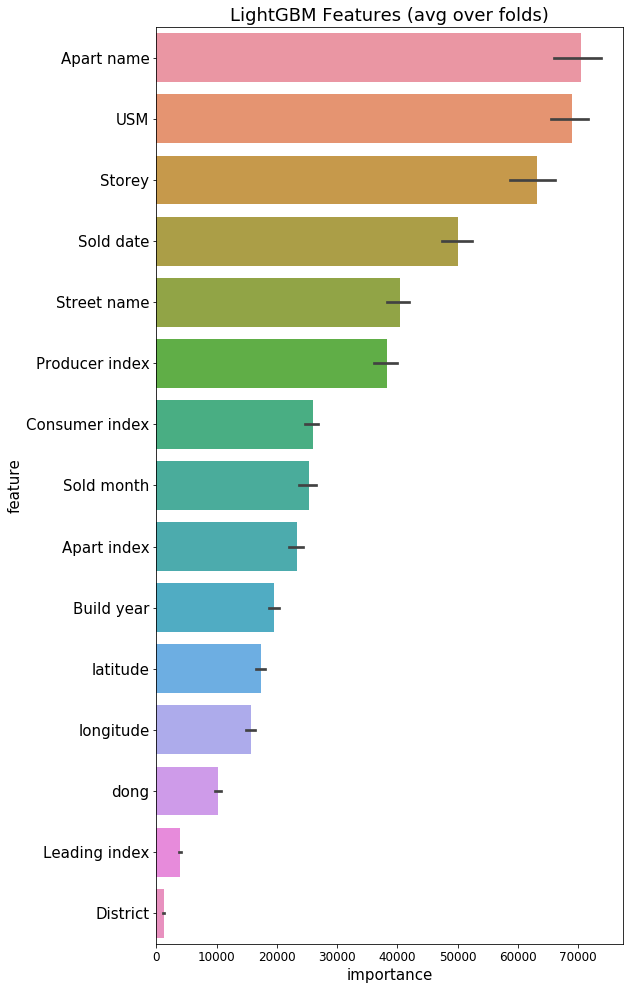

In [27]:
cols = (feature_importance_df2[["feature", "importance"]].groupby("feature").mean()
        .sort_values(by="importance", ascending=False)[:20].index)

best_features = feature_importance_df2.loc[feature_importance_df2.feature.isin(cols)]
                
plt.figure(figsize=(9,14))
plt.rc('font',size=15)
plt.rc('xtick',labelsize=12)
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('all_lgbm_importances.png')

In [28]:
#lightgbm단일모델 범주형 다씀
(abs(testTarget-lightgbmPre2)/testTarget*100).describe()

count    1192.000000
mean        6.822041
std         8.098270
min         0.002376
25%         2.131979
50%         4.591389
75%         8.544218
max        82.521687
dtype: float64

In [29]:
1-sum((testTarget-lightgbmPre2)**2)/SST

0.9677537615907846

In [49]:
###단일로 stack model
lightgbmOof,xgbOof,rfOof,olsOof,lightgbmPre,xgbPre,rfPre,olsPre

(array([466.84679106, 234.16115616, 363.40015411, ..., 508.26440599,
        581.29050106, 555.29283254]),
 array([471.84237671, 344.28436279, 340.22924805, ..., 441.81692505,
        527.90026855, 562.38818359]),
 array([442.97919718, 424.37676467, 518.00620681, ..., 514.81594225,
        523.02292476, 547.80788475]),
 array([672.71924919, 534.69925358, 620.59098385, ..., 777.48078091,
        802.70523993, 766.25551267]),
 array([ 809.50622735,  752.91875284,  317.65950497, ..., 1183.38967184,
         587.22677865,  534.42915584]),
 array([ 802.3809967 ,  753.82315063,  313.87889481, ..., 1225.06678772,
         578.32756042,  554.1060791 ]),
 array([ 811.51740503,  779.8508707 ,  351.60822804, ..., 1175.55400659,
         569.45638826,  543.36851714]),
 array([872.58517799, 886.47474086, 668.52928326, ..., 824.63672326,
        670.42992027, 788.89982973]))

In [50]:
stackData=pd.DataFrame({"rf":rfOof, "xgb":xgbOof, "light":lightgbmOof,"ols":olsOof})

In [51]:
stackTestData=pd.DataFrame({"rf":rfPre, "xgb":xgbPre, "light":lightgbmPre,"ols":olsPre})

In [52]:
stackPre=np.zeros(len(kfoldTest))
stackOof=np.zeros(len(stackData))

In [53]:
%%time
print("xgboost") 
sOof = np.zeros(len(kfoldDataWithBig))
sPre = np.zeros(len(kfoldTestWithBig)) 
folds=KFold(n_splits=5,shuffle=True,random_state=15)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(stackData,kfoldTarget)) : 
    trn_x, trn_y = stackData.iloc[trn_idx], kfoldTarget[trn_idx] 
    val_x, val_y = stackData.iloc[val_idx], kfoldTarget[val_idx] 
    params = {'objective': 'reg:linear', 
              'booster':'gbtree',                   ###Tree base 모델
              'eval_metric': 'mae', 
              'eta': 0.1,           ###학습속도 일반적으로 0.01~0.2
              'max_depth': 10,    ###트리 최대깊이 일반적으로 3~10
              'subsample': 0.9,    ###각 트리마다 관측 데이터 샘플링 비율 0.5~1
              'colsample_bytree': 0.9,   ###각 트리마다 변수 샘플링 비율 0.5~1
              'alpha':0.001,                    ###규제항 
              'random_state': 42, 
              'verbosity': 1}                ###동작메시지 출력
    tr_data = xgb.DMatrix(trn_x, trn_y) 
    va_data = xgb.DMatrix(val_x, val_y) 
    watchlist = [(tr_data, 'train'), (va_data, 'valid')] 
    model_xgb = xgb.train(params, tr_data, 10000, watchlist, maximize=False, early_stopping_rounds = 500, verbose_eval=100) 
    
    test_data = xgb.DMatrix(stackTestData) 
    sPre += model_xgb.predict(test_data) / folds.n_splits 
    sOof[val_idx] = model_xgb.predict(va_data)

xgboost


C:\Users\ju\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:12:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-mae:580.589	valid-mae:580.782
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 500 rounds.
[100]	train-mae:23.7374	valid-mae:25.1023
[200]	train-mae:23.3338	valid-mae:25.1491
[300]	train-mae:22.9532	valid-mae:25.1942
[400]	train-mae:22.598	valid-mae:25.2448
[100]	train-mae:23.6981	valid-mae:25.0689
[200]	train-mae:23.2996	valid-mae:25.118
[300]	train-mae:22.9316	valid-mae:25.1776
[400]	train-mae:22.5758	valid-mae:25.2282
[500]	train-mae:22.2492	valid-mae:25.2754
Stopping. Best iteration:
[73]	train-mae:23.8331	valid-mae:25.0564

[09:18:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-mae:580.414	valid-mae:581.514
Mult

In [54]:
#stack단일모델 xgboost 이용 
(abs(testTarget-sPre)/testTarget*100).describe()

count    1192.000000
mean        7.553452
std        10.165022
min         0.007626
25%         2.096233
50%         4.779261
75%         9.064107
max       112.349135
dtype: float64

In [55]:
1-sum((testTarget-sPre)**2)/SST

0.9592093091722309

In [56]:
###lightgbm 파라미터
param = {'num_leaves': 200,                 #default=31
         'min_data_in_leaf': 10,            #default=20
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,           ###트리만들때마다 0.01 씩 가중치 곱함
         "boosting": "gbdt",                ###워래 우리가 아는 gbdt 씀
         "feature_fraction": 0.9,          ###변수 90%만 쓰게됨
         "bagging_freq": 1,                 ###bagging 의빈도
         "bagging_fraction": 0.9,        ###데이터를 90%만 쓰게됨 resampling 없이
         "bagging_seed": 11,              ###bagging 을 위한 seed
         "metric": 'mae',
         "lambda_l1": 0.1,                  ###오메가 항에서 람다 말할는거임 가중치 옆에 붙는 weights 숫자가 클수록 보수적
         "verbosity": -1}                      ###보수적이라는말은 트리생성을 잘안할려고함

In [57]:
%%time
for order, (train_idx,valid_idx) in enumerate(folds.split(stackData, kfoldTarget)):
    print('-')
    print("Fold {}".format(order + 1))
    trn_data = lgb.Dataset(stackData.iloc[train_idx], label=kfoldTarget.iloc[train_idx])
    val_data = lgb.Dataset(stackData.iloc[valid_idx], label=kfoldTarget.iloc[valid_idx])

    num_round = 10000          ###boosting 10000번 한다는소리임 verbose_eval 은 100번마다 출력함
    ###early는 100번동안 효과없으면 그만둠
    
    clf = lgb.train(param, trn_data, num_round, valid_sets = [val_data], verbose_eval=100, early_stopping_rounds=100)
    #훈련해서 모수가 조정된 모델에 valid 데이터 넣어서 예측값 보여주는것
    stackOof[valid_idx] = clf.predict(stackData.iloc[valid_idx], num_iteration=clf.best_iteration)
    ###5개모델 다더해서 나누면 최종 예측치 되는것
    stackPre += clf.predict(stackTestData, num_iteration=clf.best_iteration) / folds.n_splits

-
Fold 1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 85.1096
[200]	valid_0's l1: 39.4632
[300]	valid_0's l1: 27.8753
[400]	valid_0's l1: 25.9062
[500]	valid_0's l1: 25.6509
[600]	valid_0's l1: 25.633
Early stopping, best iteration is:
[582]	valid_0's l1: 25.6318
-
Fold 2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 85.0033
[200]	valid_0's l1: 39.3753
[300]	valid_0's l1: 27.8958
[400]	valid_0's l1: 25.9604
[500]	valid_0's l1: 25.7183
[600]	valid_0's l1: 25.7017
Early stopping, best iteration is:
[573]	valid_0's l1: 25.7001
-
Fold 3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 85.0261
[200]	valid_0's l1: 39.364
[300]	valid_0's l1: 27.8191
[400]	valid_0's l1: 25.8872
[500]	valid_0's l1: 25.6439
[600]	valid_0's l1: 25.6289
Early stopping, best iteration is:
[578]	valid_0's l1: 25.628
-
Fold 4
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 85.083

In [58]:
#stack단일모델 
(abs(testTarget-stackPre)/testTarget*100).describe()

count    1192.000000
mean        7.805369
std        10.334366
min         0.001426
25%         2.239927
50%         4.958547
75%         9.311110
max       112.890538
dtype: float64

In [59]:
1-sum((testTarget-stackPre)**2)/SST

0.9317430312853464

In [60]:
%%time
###OLS 빼고 stack 인데 XGBoost
stackData=pd.DataFrame({"rf":rfOof, "xgb":xgbOof, "light":lightgbmOof})
stackTestData=pd.DataFrame({"rf":rfPre, "xgb":xgbPre, "light":lightgbmPre})
print("xgboost") 
sOof3 = np.zeros(len(kfoldDataWithBig))
sPre3 = np.zeros(len(kfoldTestWithBig)) 
folds=KFold(n_splits=5,shuffle=True,random_state=15)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(stackData,kfoldTarget)) : 
    trn_x, trn_y = stackData.iloc[trn_idx], kfoldTarget[trn_idx] 
    val_x, val_y = stackData.iloc[val_idx], kfoldTarget[val_idx] 
    params = {'objective': 'reg:linear', 
              'booster':'gbtree',                   ###Tree base 모델
              'eval_metric': 'mae', 
              'eta': 0.1,           ###학습속도 일반적으로 0.01~0.2
              'max_depth': 10,    ###트리 최대깊이 일반적으로 3~10
              'subsample': 0.9,    ###각 트리마다 관측 데이터 샘플링 비율 0.5~1
              'colsample_bytree': 0.9,   ###각 트리마다 변수 샘플링 비율 0.5~1
              'alpha':0.001,                    ###규제항 
              'random_state': 42, 
              'verbosity': 1}                ###동작메시지 출력
    tr_data = xgb.DMatrix(trn_x, trn_y) 
    va_data = xgb.DMatrix(val_x, val_y) 
    watchlist = [(tr_data, 'train'), (va_data, 'valid')] 
    model_xgb = xgb.train(params, tr_data, 10000, watchlist, maximize=False, early_stopping_rounds = 500, verbose_eval=100) 
    
    test_data = xgb.DMatrix(stackTestData) 
    sPre3 += model_xgb.predict(test_data) / folds.n_splits 
    sOof3[val_idx] = model_xgb.predict(va_data)

xgboost
[09:27:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-mae:580.59	valid-mae:580.779
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 500 rounds.
[100]	train-mae:23.8901	valid-mae:25.1157
[200]	train-mae:23.5667	valid-mae:25.1741
[300]	train-mae:23.2701	valid-mae:25.2194
[400]	train-mae:22.9713	valid-mae:25.2686
[500]	train-mae:22.7025	valid-mae:25.3089
Stopping. Best iteration:
[76]	train-mae:23.9827	valid-mae:25.1019

[09:29:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-mae:580.621	valid-mae:580.629
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 500 rounds.
[100]	train-mae:23.

In [61]:
#stack단일모델 
(abs(testTarget-sPre3)/testTarget*100).describe()

count    1192.000000
mean        7.609793
std        10.244067
min         0.014924
25%         2.146704
50%         4.826063
75%         9.028788
max       113.801655
dtype: float64

In [62]:
1-sum((testTarget-sPre3)**2)/SST

0.9589249477355277

In [63]:
%%time
###OLS 빼고 stack 인데 lightgbm
stackData=pd.DataFrame({"rf":rfOof, "xgb":xgbOof, "light":lightgbmOof})
stackTestData=pd.DataFrame({"rf":rfPre, "xgb":xgbPre, "light":lightgbmPre})
stackPre3=np.zeros(len(kfoldTest))
stackOof3=np.zeros(len(stackData))
for order, (train_idx,valid_idx) in enumerate(folds.split(stackData, kfoldTarget)):
    print('-')
    print("Fold {}".format(order + 1))
    trn_data = lgb.Dataset(stackData.iloc[train_idx], label=kfoldTarget.iloc[train_idx])
    val_data = lgb.Dataset(stackData.iloc[valid_idx], label=kfoldTarget.iloc[valid_idx])

    num_round = 10000          ###boosting 10000번 한다는소리임 verbose_eval 은 100번마다 출력함
    ###early는 100번동안 효과없으면 그만둠
    
    clf = lgb.train(param, trn_data, num_round, valid_sets = [val_data], verbose_eval=100, early_stopping_rounds=100)
    #훈련해서 모수가 조정된 모델에 valid 데이터 넣어서 예측값 보여주는것
    stackOof3[valid_idx] = clf.predict(stackData.iloc[valid_idx], num_iteration=clf.best_iteration)
    ###5개모델 다더해서 나누면 최종 예측치 되는것
    stackPre3 += clf.predict(stackTestData, num_iteration=clf.best_iteration) / folds.n_splits

-
Fold 1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 85.1065
[200]	valid_0's l1: 39.4789
[300]	valid_0's l1: 27.911
[400]	valid_0's l1: 25.9579
[500]	valid_0's l1: 25.7118
[600]	valid_0's l1: 25.6972
Early stopping, best iteration is:
[566]	valid_0's l1: 25.6948
-
Fold 2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 84.9898
[200]	valid_0's l1: 39.353
[300]	valid_0's l1: 27.9091
[400]	valid_0's l1: 26.0003
[500]	valid_0's l1: 25.768
[600]	valid_0's l1: 25.7583
Early stopping, best iteration is:
[571]	valid_0's l1: 25.756
-
Fold 3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 85.0466
[200]	valid_0's l1: 39.3591
[300]	valid_0's l1: 27.8323
[400]	valid_0's l1: 25.9096
[500]	valid_0's l1: 25.6693
[600]	valid_0's l1: 25.655
Early stopping, best iteration is:
[582]	valid_0's l1: 25.6544
-
Fold 4
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 85.0638


In [64]:
#stack단일모델 
(abs(testTarget-stackPre3)/testTarget*100).describe()

count    1192.000000
mean        7.848058
std        10.430997
min         0.028508
25%         2.252963
50%         4.976442
75%         9.386443
max       113.781596
dtype: float64

In [65]:
1-sum((testTarget-stackPre3)**2)/SST

0.9296399238691331

In [66]:
numlist=[10,50,100,200,500,1000,1500,2000,5000,10000,15000]
timelist=[]
scorelist=[]

In [67]:
for i in numlist:
    ###lightgbm 파라미터
    param = {'num_leaves': 200,                 #default=31  ->이걸로 하이퍼 파라미터 조정하면될듯.
             'min_data_in_leaf': 10,            #default=20
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.1,           ###트리만들때마다 0.01 씩 가중치 곱함
             "boosting": "gbdt",                ###워래 우리가 아는 gbdt 씀
             "feature_fraction": 0.9,          ###변수 90%만 쓰게됨
             "bagging_freq": 1,                 ###bagging 의빈도
             "bagging_fraction": 0.9,        ###데이터를 90%만 쓰게됨 resampling 없이
             "bagging_seed": 11,              ###bagging 을 위한 seed
             "metric": 'mae',
             "lambda_l1": 0.1,                  ###오메가 항에서 람다 말할는거임 가중치 옆에 붙는 weights 숫자가 클수록 보수적
             "verbosity": -1}                      ###보수적이라는말은 트리생성을 잘안할려고함
    
   
    lightgbmPre5=np.zeros(len(kfoldTestWithBig))
    kfoldData2=copy.deepcopy(kfoldData)
    kfoldTest2=copy.deepcopy(kfoldTest)
    del kfoldData2['Apart name']
    del kfoldData2['Street name']
    del kfoldData2['dong']
    del kfoldTest2['Apart name']
    del kfoldTest2['Street name']
    del kfoldTest2['dong']
    
    start=time.time()

    folds=KFold(n_splits=5,shuffle=True,random_state=15)
   
    for order, (train_idx,valid_idx) in enumerate(folds.split(kfoldData2, kfoldTarget)):
        print('-')
        print("Fold {}".format(order + 1))
        trn_data = lgb.Dataset(kfoldData2.iloc[train_idx], label=kfoldTarget.iloc[train_idx])
        val_data = lgb.Dataset(kfoldData2.iloc[valid_idx], label=kfoldTarget.iloc[valid_idx])

        num_round = i          ###boosting 10000번 한다는소리임 verbose_eval 은 100번마다 출력함
        ###early는 100번동안 효과없으면 그만둠
    
        clf = lgb.train(param, trn_data, num_round, valid_sets = [val_data], verbose_eval=100, early_stopping_rounds=20000)
       
        ###5개모델 다더해서 나누면 최종 예측치 되는것
        lightgbmPre5 += clf.predict(kfoldTest2, num_iteration=clf.best_iteration) / folds.n_splits

    
    timelist.append(time.time()-start)
    scorelist.append((abs(testTarget-lightgbmPre5)/testTarget*100).describe())
    scorelist.append(1-sum((testTarget-lightgbmPre5)**2)/SST)

-
Fold 1
Training until validation scores don't improve for 20000 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's l1: 113.426
-
Fold 2
Training until validation scores don't improve for 20000 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's l1: 113.849
-
Fold 3
Training until validation scores don't improve for 20000 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's l1: 113.57
-
Fold 4
Training until validation scores don't improve for 20000 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's l1: 113.365
-
Fold 5
Training until validation scores don't improve for 20000 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's l1: 113.54
-
Fold 1
Training until validation scores don't improve for 20000 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's l1: 54.8621
-
Fold 2
Training until validation scores don't improve for 20000 rounds
Did not meet early stopping. Best iterati

[100]	valid_0's l1: 44.1075
[200]	valid_0's l1: 37.4513
[300]	valid_0's l1: 34.5734
[400]	valid_0's l1: 32.559
[500]	valid_0's l1: 31.2994
[600]	valid_0's l1: 30.3707
[700]	valid_0's l1: 29.7107
[800]	valid_0's l1: 29.1926
[900]	valid_0's l1: 28.7876
[1000]	valid_0's l1: 28.4664
[1100]	valid_0's l1: 28.1643
[1200]	valid_0's l1: 27.953
[1300]	valid_0's l1: 27.7719
[1400]	valid_0's l1: 27.6041
[1500]	valid_0's l1: 27.4692
Did not meet early stopping. Best iteration is:
[1500]	valid_0's l1: 27.4692
-
Fold 4
Training until validation scores don't improve for 20000 rounds
[100]	valid_0's l1: 44.116
[200]	valid_0's l1: 37.4871
[300]	valid_0's l1: 34.3491
[400]	valid_0's l1: 32.5695
[500]	valid_0's l1: 31.4079
[600]	valid_0's l1: 30.4907
[700]	valid_0's l1: 29.7564
[800]	valid_0's l1: 29.1624
[900]	valid_0's l1: 28.7568
[1000]	valid_0's l1: 28.4037
[1100]	valid_0's l1: 28.1339
[1200]	valid_0's l1: 27.8988
[1300]	valid_0's l1: 27.7039
[1400]	valid_0's l1: 27.5155
[1500]	valid_0's l1: 27.3706
D

[4600]	valid_0's l1: 26.5991
[4700]	valid_0's l1: 26.5978
[4800]	valid_0's l1: 26.5986
[4900]	valid_0's l1: 26.5991
[5000]	valid_0's l1: 26.6029
Did not meet early stopping. Best iteration is:
[4695]	valid_0's l1: 26.5971
-
Fold 3
Training until validation scores don't improve for 20000 rounds
[100]	valid_0's l1: 44.1075
[200]	valid_0's l1: 37.4513
[300]	valid_0's l1: 34.5734
[400]	valid_0's l1: 32.559
[500]	valid_0's l1: 31.2994
[600]	valid_0's l1: 30.3707
[700]	valid_0's l1: 29.7107
[800]	valid_0's l1: 29.1926
[900]	valid_0's l1: 28.7876
[1000]	valid_0's l1: 28.4664
[1100]	valid_0's l1: 28.1643
[1200]	valid_0's l1: 27.953
[1300]	valid_0's l1: 27.7719
[1400]	valid_0's l1: 27.6041
[1500]	valid_0's l1: 27.4692
[1600]	valid_0's l1: 27.3437
[1700]	valid_0's l1: 27.2471
[1800]	valid_0's l1: 27.1511
[1900]	valid_0's l1: 27.0649
[2000]	valid_0's l1: 26.9929
[2100]	valid_0's l1: 26.9265
[2200]	valid_0's l1: 26.8864
[2300]	valid_0's l1: 26.8394
[2400]	valid_0's l1: 26.8059
[2500]	valid_0's l1:

[500]	valid_0's l1: 31.6803
[600]	valid_0's l1: 30.7542
[700]	valid_0's l1: 30.0177
[800]	valid_0's l1: 29.4375
[900]	valid_0's l1: 28.9943
[1000]	valid_0's l1: 28.7039
[1100]	valid_0's l1: 28.3711
[1200]	valid_0's l1: 28.1217
[1300]	valid_0's l1: 27.9211
[1400]	valid_0's l1: 27.7486
[1500]	valid_0's l1: 27.6002
[1600]	valid_0's l1: 27.4774
[1700]	valid_0's l1: 27.3771
[1800]	valid_0's l1: 27.2761
[1900]	valid_0's l1: 27.1794
[2000]	valid_0's l1: 27.1024
[2100]	valid_0's l1: 27.0242
[2200]	valid_0's l1: 26.9686
[2300]	valid_0's l1: 26.9213
[2400]	valid_0's l1: 26.8797
[2500]	valid_0's l1: 26.8479
[2600]	valid_0's l1: 26.818
[2700]	valid_0's l1: 26.7862
[2800]	valid_0's l1: 26.7534
[2900]	valid_0's l1: 26.7286
[3000]	valid_0's l1: 26.7129
[3100]	valid_0's l1: 26.6979
[3200]	valid_0's l1: 26.6828
[3300]	valid_0's l1: 26.6643
[3400]	valid_0's l1: 26.6487
[3500]	valid_0's l1: 26.644
[3600]	valid_0's l1: 26.6337
[3700]	valid_0's l1: 26.6285
[3800]	valid_0's l1: 26.6227
[3900]	valid_0's l1: 

[7900]	valid_0's l1: 26.5708
[8000]	valid_0's l1: 26.5772
[8100]	valid_0's l1: 26.5827
[8200]	valid_0's l1: 26.5901
[8300]	valid_0's l1: 26.598
[8400]	valid_0's l1: 26.6061
[8500]	valid_0's l1: 26.6106
[8600]	valid_0's l1: 26.6176
[8700]	valid_0's l1: 26.624
[8800]	valid_0's l1: 26.629
[8900]	valid_0's l1: 26.6341
[9000]	valid_0's l1: 26.6406
[9100]	valid_0's l1: 26.6479
[9200]	valid_0's l1: 26.6547
[9300]	valid_0's l1: 26.6607
[9400]	valid_0's l1: 26.6669
[9500]	valid_0's l1: 26.6727
[9600]	valid_0's l1: 26.679
[9700]	valid_0's l1: 26.6872
[9800]	valid_0's l1: 26.6946
[9900]	valid_0's l1: 26.7005
[10000]	valid_0's l1: 26.7051
Did not meet early stopping. Best iteration is:
[4871]	valid_0's l1: 26.4077
-
Fold 5
Training until validation scores don't improve for 20000 rounds
[100]	valid_0's l1: 44.0523
[200]	valid_0's l1: 37.8033
[300]	valid_0's l1: 34.643
[400]	valid_0's l1: 32.7009
[500]	valid_0's l1: 31.3735
[600]	valid_0's l1: 30.5058
[700]	valid_0's l1: 29.7351
[800]	valid_0's l1: 

-
Fold 2
Training until validation scores don't improve for 20000 rounds
[100]	valid_0's l1: 44.3085
[200]	valid_0's l1: 37.4235
[300]	valid_0's l1: 34.7178
[400]	valid_0's l1: 32.8884
[500]	valid_0's l1: 31.6803
[600]	valid_0's l1: 30.7542
[700]	valid_0's l1: 30.0177
[800]	valid_0's l1: 29.4375
[900]	valid_0's l1: 28.9943
[1000]	valid_0's l1: 28.7039
[1100]	valid_0's l1: 28.3711
[1200]	valid_0's l1: 28.1217
[1300]	valid_0's l1: 27.9211
[1400]	valid_0's l1: 27.7486
[1500]	valid_0's l1: 27.6002
[1600]	valid_0's l1: 27.4774
[1700]	valid_0's l1: 27.3771
[1800]	valid_0's l1: 27.2761
[1900]	valid_0's l1: 27.1794
[2000]	valid_0's l1: 27.1024
[2100]	valid_0's l1: 27.0242
[2200]	valid_0's l1: 26.9686
[2300]	valid_0's l1: 26.9213
[2400]	valid_0's l1: 26.8797
[2500]	valid_0's l1: 26.8479
[2600]	valid_0's l1: 26.818
[2700]	valid_0's l1: 26.7862
[2800]	valid_0's l1: 26.7534
[2900]	valid_0's l1: 26.7286
[3000]	valid_0's l1: 26.7129
[3100]	valid_0's l1: 26.6979
[3200]	valid_0's l1: 26.6828
[3300]	va

[12500]	valid_0's l1: 27.0577
[12600]	valid_0's l1: 27.0636
[12700]	valid_0's l1: 27.0697
[12800]	valid_0's l1: 27.0751
[12900]	valid_0's l1: 27.0808
[13000]	valid_0's l1: 27.0867
[13100]	valid_0's l1: 27.0897
[13200]	valid_0's l1: 27.0966
[13300]	valid_0's l1: 27.1024
[13400]	valid_0's l1: 27.1086
[13500]	valid_0's l1: 27.1133
[13600]	valid_0's l1: 27.1194
[13700]	valid_0's l1: 27.1234
[13800]	valid_0's l1: 27.1289
[13900]	valid_0's l1: 27.1338
[14000]	valid_0's l1: 27.1373
[14100]	valid_0's l1: 27.1423
[14200]	valid_0's l1: 27.1472
[14300]	valid_0's l1: 27.1517
[14400]	valid_0's l1: 27.1549
[14500]	valid_0's l1: 27.1599
[14600]	valid_0's l1: 27.1656
[14700]	valid_0's l1: 27.1689
[14800]	valid_0's l1: 27.1748
[14900]	valid_0's l1: 27.1784
[15000]	valid_0's l1: 27.1819
Did not meet early stopping. Best iteration is:
[4449]	valid_0's l1: 26.5819
-
Fold 4
Training until validation scores don't improve for 20000 rounds
[100]	valid_0's l1: 44.116
[200]	valid_0's l1: 37.4871
[300]	valid_0's

[9700]	valid_0's l1: 26.668
[9800]	valid_0's l1: 26.6756
[9900]	valid_0's l1: 26.6802
[10000]	valid_0's l1: 26.6864
[10100]	valid_0's l1: 26.6942
[10200]	valid_0's l1: 26.7006
[10300]	valid_0's l1: 26.7087
[10400]	valid_0's l1: 26.7161
[10500]	valid_0's l1: 26.7218
[10600]	valid_0's l1: 26.7267
[10700]	valid_0's l1: 26.7351
[10800]	valid_0's l1: 26.7388
[10900]	valid_0's l1: 26.7442
[11000]	valid_0's l1: 26.7502
[11100]	valid_0's l1: 26.7554
[11200]	valid_0's l1: 26.762
[11300]	valid_0's l1: 26.7679
[11400]	valid_0's l1: 26.7731
[11500]	valid_0's l1: 26.7771
[11600]	valid_0's l1: 26.7846
[11700]	valid_0's l1: 26.7902
[11800]	valid_0's l1: 26.7966
[11900]	valid_0's l1: 26.8022
[12000]	valid_0's l1: 26.8077
[12100]	valid_0's l1: 26.8152
[12200]	valid_0's l1: 26.8198
[12300]	valid_0's l1: 26.8251
[12400]	valid_0's l1: 26.8318
[12500]	valid_0's l1: 26.8376
[12600]	valid_0's l1: 26.8438
[12700]	valid_0's l1: 26.8488
[12800]	valid_0's l1: 26.8549
[12900]	valid_0's l1: 26.8592
[13000]	valid_0

In [68]:
timelist

[4.758282423019409,
 10.489011526107788,
 19.94061517715454,
 28.327826499938965,
 54.890660524368286,
 104.23703050613403,
 144.61743140220642,
 185.91385316848755,
 430.26734232902527,
 853.095929145813,
 1310.8119144439697]

In [69]:
scorelist

[count    1192.000000
 mean       22.572141
 std        20.140079
 min         0.029191
 25%        10.056658
 50%        18.978385
 75%        29.039433
 max       197.203512
 dtype: float64, 0.6521300874734631, count    1192.000000
 mean       16.031441
 std        17.852163
 min         0.003075
 25%         5.622098
 50%        11.056769
 75%        19.901435
 max       183.899839
 dtype: float64, 0.8804218842165278, count    1192.000000
 mean       13.070091
 std        15.239633
 min         0.005991
 25%         4.199614
 50%         8.989971
 75%        15.351194
 max       162.306285
 dtype: float64, 0.9165609085364336, count    1192.000000
 mean       10.806654
 std        13.314172
 min         0.002557
 25%         3.250426
 50%         7.322967
 75%        12.722425
 max       144.656881
 dtype: float64, 0.9381224377228707, count    1192.000000
 mean        8.939045
 std        11.715659
 min         0.013833
 25%         2.552555
 50%         5.885364
 75%        10.52620